In [1]:
import os
import pytest
import numpy as np
import matplotlib.pyplot as plt

from temgymbasic.model import (
    Model,
)

from temgymbasic.utils import calculate_phi_0
import temgymbasic.components as comp
from temgymbasic.utils import zero_phase, zero_phase_1D, FresnelPropagator, lens_phase_factor
from diffractio.scalar_sources_XY import Scalar_source_XY

# Import and configure ipytest
import ipytest
ipytest.autoconfig()

try:
    import cupy as cp
except ImportError:
    cp = None

# Check environment variable to decide backend
USE_GPU = os.getenv('USE_GPU', '0') == '1'

if USE_GPU:
    xp = cp
else:
    xp = np

%matplotlib widget

c:\Users\dl277493\AppData\Local\miniforge3\envs\temgym\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
@pytest.fixture(params=[
    (0, 0, 0.0),
    (3, 0, 0.0),
    (0, -3, 0.0),
    (-3, 3, 0.0),
])
def gaussian_beam_freespace_model(request):
    wavelength = 0.01
    size = 512
    pixel_size = 0.01
    wo = 0.1
    prop_dist = 25

    theta_x, theta_y, x0 = request.param

    det_shape = (size, size)

    deg_yx = np.deg2rad((theta_y, theta_x))
    tilt_yx = np.tan(deg_yx)

    components = (
        comp.GaussBeam(
            z=0.0,
            voltage=calculate_phi_0(wavelength),
            radius=x0,
            wo=wo,
            tilt_yx=tilt_yx
        ),
        comp.AccumulatingDetector(
            z=prop_dist,
            pixel_size=pixel_size,
            shape=det_shape,
            buffer_length=64,
        ),
    )

    model = Model(components)

    return model, wavelength, deg_yx, x0, wo, prop_dist


# @pytest.fixture(params=[
#     (0, 0, 0.1),
#     (0, 0, 0.0),
#     (5, 0, 0.0),
#     (0, -5, 0.0),
#     (-5, 5, 0.0),
# ])
def gaussian_beam_lens_model(x0):
    wavelength = 0.01
    size = 512
    pixel_size = 0.002
    wo = 0.04

    theta_x, theta_y, x0 = (0, 0, x0)#request.param

    det_shape = (size, size)

    deg_yx = np.deg2rad((theta_y, theta_x))
    tilt_yx = np.tan(deg_yx)

    lens_dist = 1
    f = 2
    prop_dist = f

    components = (
        comp.GaussBeam(
            z=0.0,
            voltage=calculate_phi_0(wavelength),
            radius=0,
            wo=wo,
            tilt_yx=tilt_yx,
            centre_yx=(0, x0),
        ),
        comp.Lens(
            z=lens_dist,
            f=f,
        ),
        comp.Detector(
            z=lens_dist + prop_dist,
            pixel_size=pixel_size,
            shape=det_shape,
        ),
    )

    model = Model(components)

    return model, wavelength, deg_yx, x0, wo, prop_dist, lens_dist, f

@pytest.fixture(params=[
    (0, 0, 0.0),
])
def gaussian_beam_defocus_model(request):
    wavelength = 0.01
    size = 512
    pixel_size = 0.01
    wo = 0.5

    theta_x, theta_y, x0 = request.param

    det_shape = (size, size)

    deg_yx = np.deg2rad((theta_y, theta_x))
    tilt_yx = np.tan(deg_yx)

    z1 = -10
    z2 = 10
    f = (1 / z2 - 1 / z1)**-1

    defocus = 1

    components = (
        comp.GaussBeam(
            z=0.0,
            voltage=calculate_phi_0(wavelength),
            radius=x0,
            wo=wo,
            tilt_yx=tilt_yx
        ),
        comp.Lens(
            z=np.abs(z1),
            f=f,
        ),
        comp.AccumulatingDetector(
            z=np.abs(z1) + z2 + defocus,
            pixel_size=pixel_size,
            shape=det_shape,
            buffer_length=64,
        ),
    )

    model = Model(components)

    return model, wavelength, deg_yx, x0, wo, z1, z2, f, defocus


Freespace

....                                                                                         [100%]
======================================== warnings summary =========================================
tests/gaussian_beam_tests/t_70a557293e5c4931aba429d20c88acae.py::test_gaussian_with_free_space[gaussian_beam_freespace_model0]
tests/gaussian_beam_tests/t_70a557293e5c4931aba429d20c88acae.py::test_gaussian_with_free_space[gaussian_beam_freespace_model1]
tests/gaussian_beam_tests/t_70a557293e5c4931aba429d20c88acae.py::test_gaussian_with_free_space[gaussian_beam_freespace_model2]
tests/gaussian_beam_tests/t_70a557293e5c4931aba429d20c88acae.py::test_gaussian_with_free_space[gaussian_beam_freespace_model3]
  \\grenfshome01\DL277493\TemGym\src\temgymbasic\utils.py:320: RuntimeWarning: invalid value encountered in sqrt
    radius * xp.sqrt((ii + 0.5) / (nb_samples - 0.5 * (np_boundary + 1)))

tests/gaussian_beam_tests/t_70a557293e5c4931aba429d20c88acae.py: 16 warnings
  c:\Users\dl277493\AppData

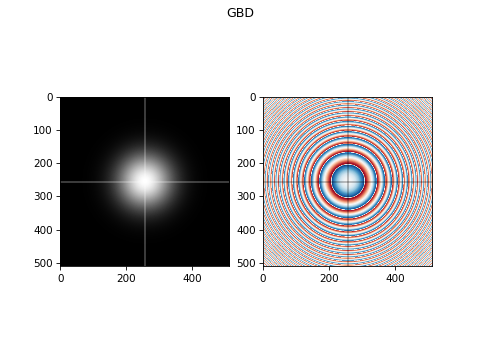

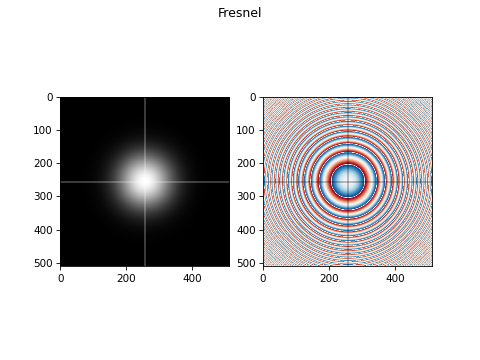

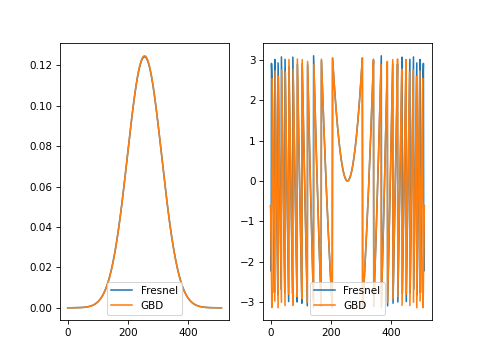

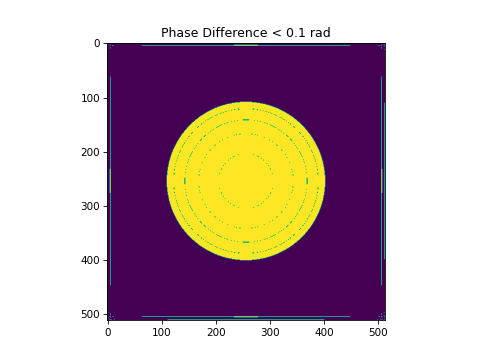

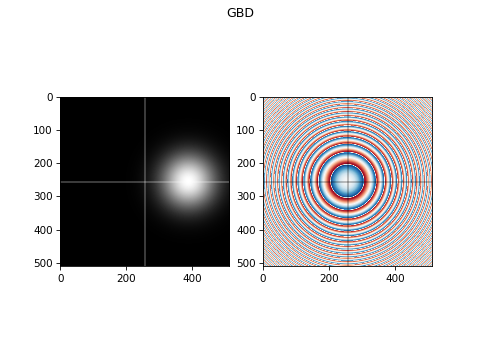

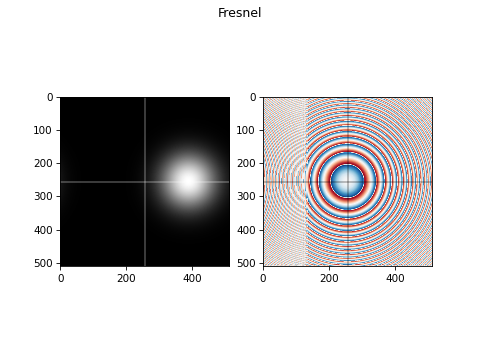

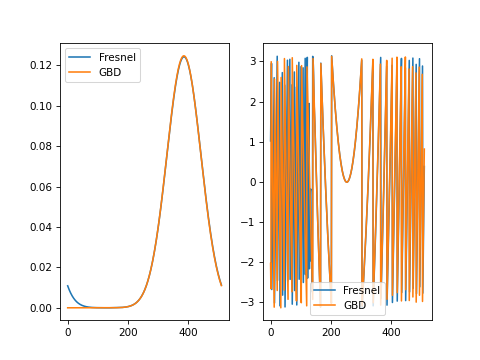

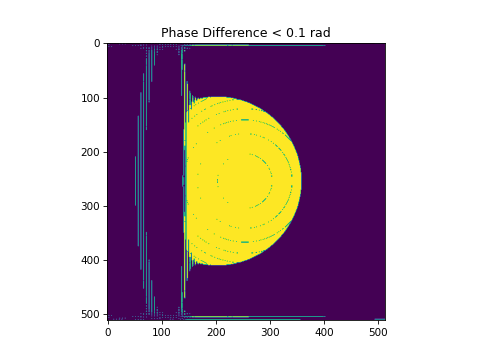

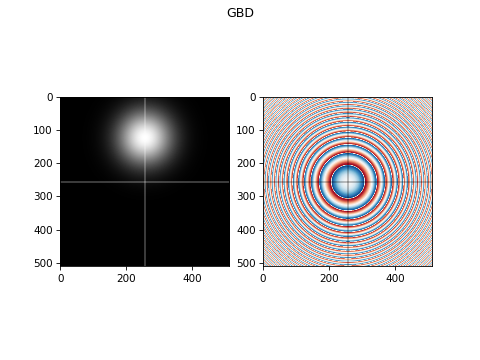

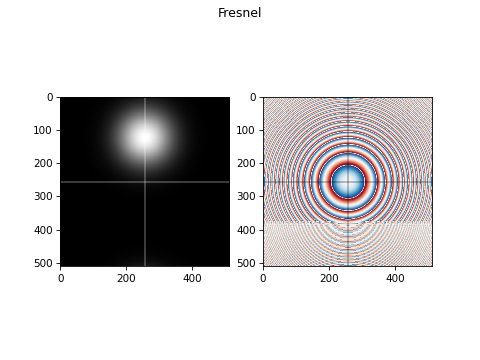

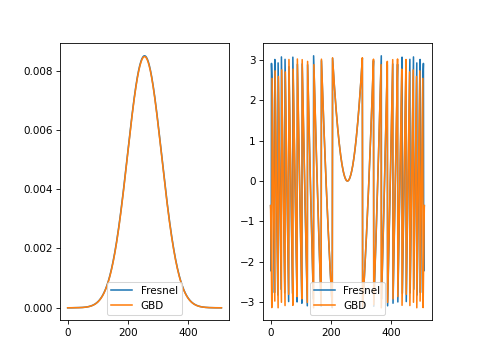

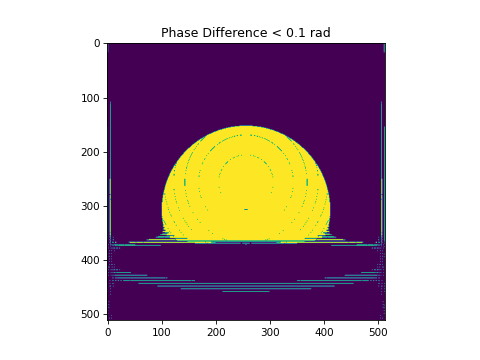

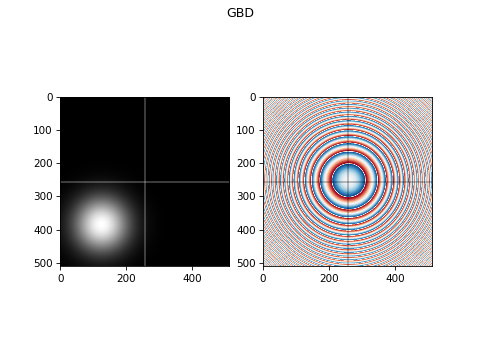

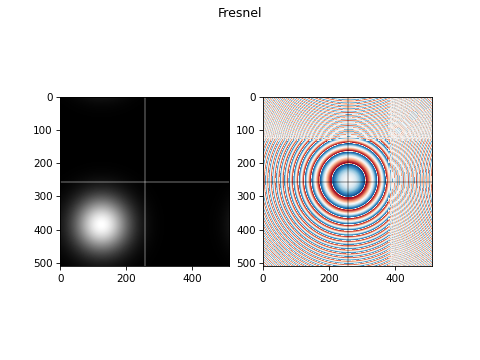

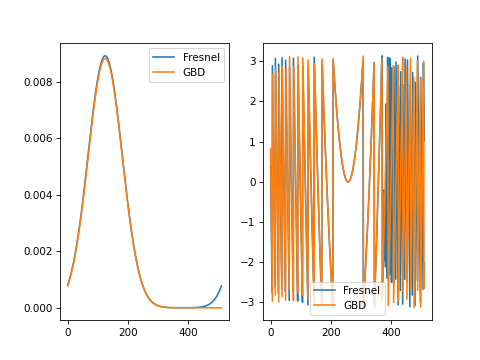

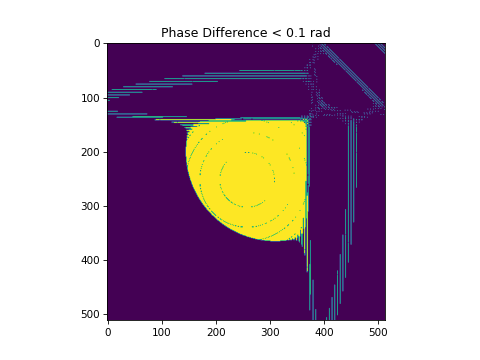

In [3]:
%%ipytest -qq

def test_gaussian_with_free_space(gaussian_beam_freespace_model):
    
    n_rays = 1
    model, wavelength, deg_yx, x0, wo, prop_dist = gaussian_beam_freespace_model

    rays = tuple(model.run_iter(num_rays=n_rays, random=False))
    gbd_output_field = model.detector.get_image(rays)

    size = gbd_output_field.shape[0]

    gbd_output_field = zero_phase(gbd_output_field,
                                    gbd_output_field.shape[0]//2,
                                    gbd_output_field.shape[1]//2)

    # Calculate theta and phi
    tan_theta_x = np.tan(deg_yx[1])
    tan_theta_y = np.tan(deg_yx[0])

    pixel_size = model.components[1].pixel_size

    theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
    phi = np.arctan2(tan_theta_y, tan_theta_x)

    shape = model.components[-1].shape
    det_size_y = shape[0] * pixel_size
    det_size_x = shape[1] * pixel_size

    x_det = xp.linspace(-det_size_x / 2, det_size_x / 2, shape[0])
    y_det = xp.linspace(-det_size_y / 2, det_size_y / 2, shape[1])

    fresnel_input_field = Scalar_source_XY(x=x_det, y=y_det, wavelength=wavelength)
    fresnel_input_field.gauss_beam(A=1, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)
    fresnel_output_field = FresnelPropagator(fresnel_input_field.u,
                                                pixel_size,
                                                wavelength,
                                                prop_dist)

    fresnel_output_field = zero_phase(fresnel_output_field, size//2, size//2)

    # Create a mask for pixels within a 25 px radius from the center
    center_x, center_y = size // 2, size // 2
    y, x = np.ogrid[:size, :size]
    mask = xp.sqrt((x - center_x)**2 + (y - center_y)**2) <= 25

    # Check if all pixels within the mask satisfy the isclose condition
    is_close = np.isclose(
        np.angle(gbd_output_field),
        np.angle(fresnel_output_field),
        atol=0.1,
    )

    # xp.testing.assert_(np.all(is_close[mask]))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.abs(gbd_output_field), cmap='gray')
    ax1.axvline(size // 2, color='white', alpha=0.3)
    ax1.axhline(size // 2, color='white', alpha=0.3)
    ax2.imshow(np.angle(gbd_output_field), cmap='RdBu')
    ax2.axvline(size // 2, color='k', alpha=0.3)
    ax2.axhline(size // 2, color='k', alpha=0.3)
    fig.suptitle("GBD")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.abs(fresnel_output_field), cmap='gray')
    ax1.axvline(size // 2, color='white', alpha=0.3)
    ax1.axhline(size // 2, color='white', alpha=0.3)
    ax2.imshow(np.angle(fresnel_output_field), cmap='RdBu')
    ax2.axvline(size // 2, color='k', alpha=0.3)
    ax2.axhline(size // 2, color='k', alpha=0.3)
    fig.suptitle("Fresnel")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    s = np.s_[size // 2, :]
    ax1.plot(np.abs(fresnel_output_field[s]), label="Fresnel")
    ax1.plot(np.abs(gbd_output_field[s]), label="GBD")
    ax1.legend()
    ax2.plot(np.angle(fresnel_output_field[s]), label="Fresnel")
    ax2.plot(np.angle(gbd_output_field[s]), label="GBD")
    ax2.legend()

    fig, ax1 = plt.subplots()
    ax1.set_title("Phase Difference < 0.1 rad")
    ax1.imshow(is_close)

Lens

\\grenfshome01\DL277493\TemGym\src\temgymbasic\utils.py:320: RuntimeWarning: invalid value encountered in sqrt
  radius * xp.sqrt((ii + 0.5) / (nb_samples - 0.5 * (np_boundary + 1)))
C:\Users\dl277493\AppData\Local\Temp\ipykernel_26340\1555208823.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2)


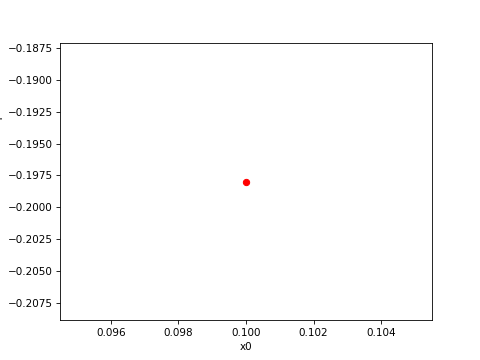

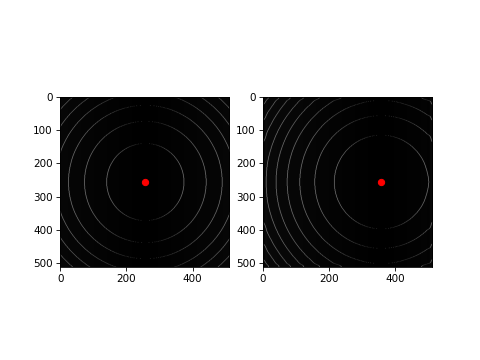

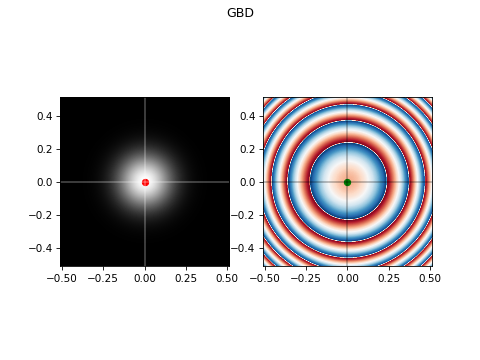

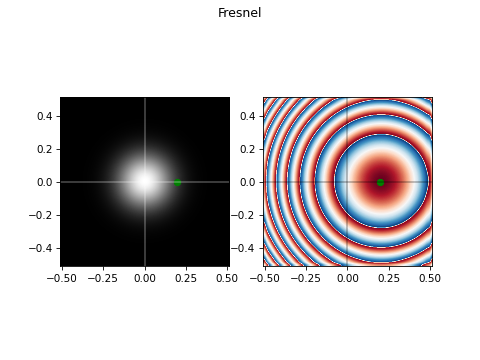

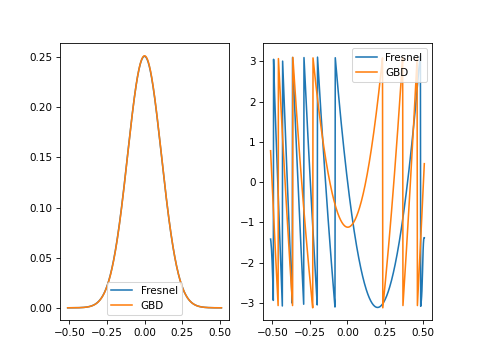

In [ ]:
# %%ipytest -qq

def test_gaussian_beam_with_lens(gaussian_beam_lens_model):
    x0s = np.linspace(0.10, 0.10, 1)

    plt.figure()

    for x0 in x0s:
        n_rays = 1
        model, wavelength, deg_yx, _, wo, prop_dist, lens_dist, focal = gaussian_beam_lens_model(x0)
W
        rays = tuple(model.run_iter(num_rays=n_rays, random=False))
        gbd_output_field = model.detector.get_image(rays)

        size = gbd_output_field.shape[0]

        # gbd_output_field = zero_phase(gbd_output_field,
        #                             gbd_output_field.shape[0]//2,
        #                             gbd_output_field.shape[1]//2)
        
        # Calculate theta and phi
        tan_theta_x = np.tan(deg_yx[1])
        tan_theta_y = np.tan(deg_yx[0])

        pixel_size = model.components[2].pixel_size

        phase_derivative_gbd = np.abs(np.diff(np.angle(gbd_output_field)))
        min_phase_derivative_gbd  = np.unravel_index(phase_derivative_gbd.argmin(), phase_derivative_gbd.shape)
        min_phase_derivative_yx_gbd  = ((min_phase_derivative_gbd [1] - size//2) * pixel_size, 0)

        theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
        phi = np.arctan2(tan_theta_y, tan_theta_x)

        shape = model.components[-1].shape
        det_size_y = shape[0] * pixel_size
        det_size_x = shape[1] * pixel_size

        x_det = xp.linspace(-det_size_x / 2, det_size_x / 2, shape[0])
        y_det = xp.linspace(-det_size_y / 2, det_size_y / 2, shape[1])

        # Calculate theta and phi
        tan_theta_x = np.tan(deg_yx[1])
        tan_theta_y = np.tan(deg_yx[0])

        theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
        phi = np.arctan2(tan_theta_y, tan_theta_x)

        fresnel_input_field = Scalar_source_XY(x=x_det, y=y_det, wavelength=wavelength)
        fresnel_input_field.gauss_beam(A=1, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)

        fresnel_output_field = FresnelPropagator(fresnel_input_field.u, pixel_size, wavelength, lens_dist)
        fresnel_output_field = fresnel_output_field * lens_phase_factor(size, pixel_size, wavelength, focal)
        fresnel_output_field = FresnelPropagator(fresnel_output_field, pixel_size, wavelength, prop_dist)
        fresnel_output_field = zero_phase(fresnel_output_field, size//2, size//2)

        phase_derivative_fresnel = np.abs(np.diff(np.angle(fresnel_output_field)))
        min_phase_derivative_fresnel  = np.unravel_index(phase_derivative_fresnel.argmin(), phase_derivative_fresnel.shape)
        min_phase_derivative_yx_fresnel  = ((min_phase_derivative_fresnel[1] - size//2) * pixel_size, 0)

        plt.scatter(x0, min_phase_derivative_yx_gbd[0] - min_phase_derivative_yx_fresnel[0], c='r', label='x difference')
        plt.xlabel('x0')
        plt.ylabel('Difference between centre of phase')
        # plt.scatter(x0, min_phase_derivative_gbd[0] - min_phase_derivative_fresnel[0], c='b', label='phase difference')

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.abs(phase_derivative_gbd), cmap='gray')
    ax1.plot(min_phase_derivative_gbd[1], 256, 'ro')
    ax2.imshow(np.abs(phase_derivative_fresnel), cmap='gray')
    ax2.plot(min_phase_derivative_fresnel[1], 256, 'ro')

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.abs(gbd_output_field), cmap='gray', extent=[-det_size_x/2, det_size_x/2, -det_size_y/2, det_size_y/2])
    ax1.plot(min_phase_derivative_yx_gbd[0], min_phase_derivative_yx_gbd[1], 'ro')
    ax1.axvline(0, color='white', alpha=0.3)
    ax1.axhline(0, color='white', alpha=0.3)
    ax2.imshow(np.angle(gbd_output_field), cmap='RdBu', extent=[-det_size_x/2, det_size_x/2, -det_size_y/2, det_size_y/2])
    ax2.plot(min_phase_derivative_yx_gbd[0], min_phase_derivative_yx_gbd[1], 'go')
    ax2.axvline(0, color='k', alpha=0.3)
    ax2.axhline(0, color='k', alpha=0.3)
    fig.suptitle("GBD")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.abs(fresnel_output_field), cmap='gray', extent=[-det_size_x/2, det_size_x/2, -det_size_y/2, det_size_y/2])
    ax1.plot(min_phase_derivative_yx_fresnel[0], min_phase_derivative_yx_fresnel[1], 'go')
    ax1.axvline(0, color='white', alpha=0.3)
    ax1.axhline(0, color='white', alpha=0.3)
    ax2.imshow(np.angle(fresnel_output_field), cmap='RdBu', extent=[-det_size_x/2, det_size_x/2, -det_size_y/2, det_size_y/2])
    ax2.plot(min_phase_derivative_yx_fresnel[0], min_phase_derivative_yx_fresnel[1], 'go')
    ax2.axvline(0, color='k', alpha=0.3)
    ax2.axhline(0, color='k', alpha=0.3)
    fig.suptitle("Fresnel")

    fig, (ax1, ax2) = plt.subplots(1, 2)
    s = np.s_[size // 2, :]
    ax1.plot(x_det, np.abs(fresnel_output_field[s]), label="Fresnel")
    ax1.plot(x_det, np.abs(gbd_output_field[s]), label="GBD")
    ax1.legend()
    ax2.plot(x_det, np.angle(fresnel_output_field[s]), label="Fresnel")
    ax2.plot(x_det, np.angle(gbd_output_field[s]), label="GBD")
    ax2.legend()

test_gaussian_beam_with_lens(gaussian_beam_lens_model)

Making sure that our Fresnel Propagator is accurate against the analytic methods for gaussian beam propagation.

.                                                                                            [100%]
======================================== warnings summary =========================================
tests/gaussian_beam_tests/t_5b0a395dc4f440a79c3801d0cad16574.py::test_fresnel_against_analytical_gaussian_beam_propagation
  c:\Users\dl277493\AppData\Local\miniforge3\envs\temgym\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
  NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
  This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
    warn(

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html


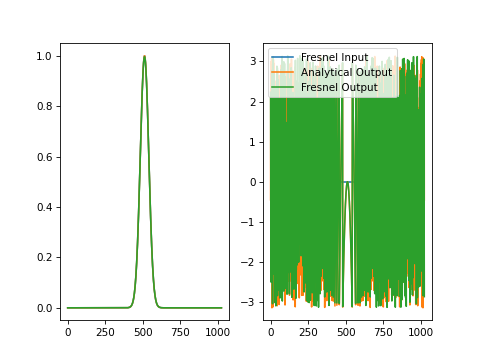

In [5]:
%%ipytest -qq

def test_fresnel_against_analytical_gaussian_beam_propagation():
    # Rayleigh Range
    def R(z, z_r):
        return z * (1 + (z_r / z) ** 2)

    # Initial complex curvature
    def get_qinv(z_r):
        qinv = 1 / (1j * z_r)
        return qinv

    def get_amplitude(A, B, Qpinv, Amplitude):
        return Amplitude / np.sqrt((A + B * Qpinv))
    
    # Gaussian Beam Parameters
    Initial_Amplitude = 1.0
    wavelength = 0.04
    x0 = 0.0
    wo = 0.4
    z_r = np.pi * wo ** 2 / wavelength

    # Calculate theta and phi
    deg_yx = np.deg2rad((0, 0))
    tan_theta_x = np.tan(deg_yx[1])
    tan_theta_y = np.tan(deg_yx[0])

    # Detector Parameters
    size = (1024, 1024)
    pixel_size = 0.01
    det_size_y = size[0] * pixel_size
    det_size_x = size[1] * pixel_size

    x_det = xp.linspace(-det_size_x / 2, det_size_x / 2, size[0])
    y_det = xp.linspace(-det_size_y / 2, det_size_y / 2, size[1])

    # Experiment Parameters and Transfer Matrix
    z1 = -5.0
    z2 = 5.0

    focal = (1 / z2 - 1 / z1) ** -1

    start_to_lens_transfer_matrix = np.array([[1, np.abs(z1)], [0, 1]])
    lens_transfer_matrix = np.array([[1, 0], [-1/focal, 1]])
    lens_to_end_transfer_matrix = np.array([[1, np.abs(z2)], [0, 1]])

    ABCD = lens_to_end_transfer_matrix @ lens_transfer_matrix @ start_to_lens_transfer_matrix
    A, B, C, D = ABCD[0, 0], ABCD[0, 1], ABCD[1, 0], ABCD[1, 1]
    
    # Analytical Gaussian Beam Output
    q_inv = get_qinv(z_r)
    Propagated_Amplitude = get_amplitude(A, B, q_inv, Initial_Amplitude)

    q1 = 1 / q_inv
    q2 = (A * q1 + B) / (C * q1 + D)

    guoy = np.arctan(np.abs(q2) / z_r)
    # r = np.sqrt(x_det ** 2 + y_det ** 2)
    analytical_output = np.abs(Propagated_Amplitude) ** 2 * np.exp(-1j * (np.pi / (q2 * wavelength)) * (x_det ** 2)) * np.exp(-1j * guoy)
    analytical_output = zero_phase_1D(analytical_output, size[0] // 2)

    # Fresnel Propagation Experimental Parameters
    theta = np.arctan(np.sqrt(tan_theta_x ** 2 + tan_theta_y ** 2))
    phi = np.arctan2(tan_theta_y, tan_theta_x)

    # Fresnel Propagation with Diffraction and our Fresnel Propagator
    fresnel_input_field = Scalar_source_XY(x=x_det, y=y_det, wavelength=wavelength)
    fresnel_input_field.gauss_beam(A=Initial_Amplitude, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)

    fresnel_output_field = FresnelPropagator(fresnel_input_field.u, pixel_size, wavelength, np.abs(z1))
    fresnel_output_field = fresnel_output_field * lens_phase_factor(size[0], pixel_size, wavelength, focal)
    fresnel_output_field = FresnelPropagator(fresnel_output_field, pixel_size, wavelength, np.abs(z2))
    fresnel_output_field = zero_phase(fresnel_output_field, size[0] // 2, size[1] // 2)

    # Create a mask for pixels within a 25 px radius from the center
    center_x, center_y = size[0] // 2, size[1] // 2
    y, x = np.ogrid[:size[0], :size[1]]
    mask = xp.sqrt((x - center_x) ** 2 + (y - center_y) ** 2) <= 5

    # Not possible with the lens to test properly - too much deviation outside the centre of the lens
    # Check if all pixels within the mask satisfy the isclose condition
    is_close = np.isclose(
        np.angle(analytical_output),
        np.angle(fresnel_output_field),
        atol=0.4,
    )

    xp.testing.assert_(np.all(is_close[mask]))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    s = np.s_[size[0] // 2, :]
    ax1.plot(np.abs(fresnel_input_field.u[s]), label="Fresnel Input")
    ax1.plot(np.abs(analytical_output), label="Analytical Output")
    ax1.plot(np.abs(fresnel_output_field[s]), label="Fresnel Output")
    ax2.plot(np.angle(fresnel_input_field.u[s]), label="Fresnel Input")
    ax2.plot(np.angle(analytical_output), label="Analytical Output")
    ax2.plot(-np.angle(fresnel_output_field[s]), label="Fresnel Output")

    ax2.plot()
    ax2.legend()


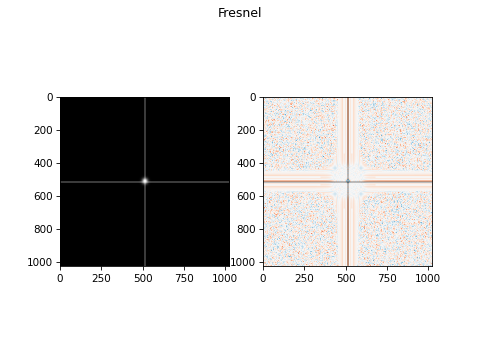

.                                                                                            [100%]
======================================== warnings summary =========================================
tests/gaussian_beam_tests/t_5b0a395dc4f440a79c3801d0cad16574.py::test_defocused_beam[gaussian_beam_defocus_model0]
  c:\Users\dl277493\AppData\Local\miniforge3\envs\temgym\Lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
  NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
  This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
    warn(

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html


In [6]:
%%ipytest -qq
#Test Defocus of Gaussian Point Source
def test_defocused_beam(gaussian_beam_defocus_model):

    model, wavelength, deg_yx, x0, wo, z1, z2, focal, defocus = gaussian_beam_defocus_model
    
    # Gaussian Beam Parameters
    Initial_Amplitude = 1.0
    wavelength = 0.001
    x0 = 0.0
    wo = 0.03
    z_r = np.pi * wo ** 2 / wavelength

    # Calculate theta and phi
    deg_yx = np.deg2rad((0, 0))
    tan_theta_x = np.tan(deg_yx[1])
    tan_theta_y = np.tan(deg_yx[0])

    theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
    phi = np.arctan2(tan_theta_y, tan_theta_x)

    # Detector Parameters
    size = (1024, 1024)
    pixel_size = 0.01

    det_size_y = size[0] * pixel_size
    det_size_x = size[1] * pixel_size

    x_det = xp.linspace(-det_size_x / 2, det_size_x / 2, size[0])
    y_det = xp.linspace(-det_size_y / 2, det_size_y / 2, size[1])
    
    fresnel_input_field = np.zeros(size, dtype=np.complex128)
    fresnel_input_field[size[0]//2, size[1]//2] = 1 + 0j

    fresnel_input_field = Scalar_source_XY(x=x_det, y=y_det, wavelength=wavelength)
    fresnel_input_field.gauss_beam(A=1, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)
    
    fresnel_output_field = fresnel_input_field.u * lens_phase_factor(size[0], pixel_size, wavelength, focal)
    fresnel_output_field = FresnelPropagator(fresnel_output_field, pixel_size, wavelength, np.abs(z2) + 5)
    fresnel_output_field = zero_phase(fresnel_output_field, size[0]//2, size[1]//2)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.abs(fresnel_output_field), cmap='gray')
    ax1.axvline(size[0] // 2, color='white', alpha=0.3)
    ax1.axhline(size[0] // 2, color='white', alpha=0.3)
    ax2.imshow(np.angle(fresnel_output_field), cmap='RdBu')
    ax2.axvline(size[0] // 2, color='k', alpha=0.3)
    ax2.axhline(size[0] // 2, color='k', alpha=0.3)
    fig.suptitle("Fresnel")

    plt.show()
    


In [7]:
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_fields_XZ import Scalar_field_XZ

wavelength = 0.001
size_x = 256
size_z = 1000
radius = 4
focal = 2000
defocus = 100
z_start = 0
z_lens = 1000
z_end = 3000
x0, dx = np.linspace(-6, 6, size_x, retstep=True)
z0 = np.linspace(1000, 3000, size_z)

Fnum = focal / (2 * radius)
defocus = 8 * 1 * wavelength * Fnum ** 2
print(defocus)

# t1 = Scalar_mask_X(x0, wavelength)
# t1.lens(x0=0, radius=radius, focal=focal)

# u0 = Scalar_source_X(x0, wavelength)
# u0.plane_wave(A=1, theta=0)
# u1 = u0 * t1


# u2 = Scalar_field_XZ(x=x0, z=z0, wavelength=wavelength)
# u2.incident_field(u1)
# u2.WPM()

# u2.draw(logarithm=True, draw_borders=False, scale='')
# plt.ylim(-radius * 2, radius * 2)

# u2.draw_profiles_interactive(kind='amplitude')

500.0


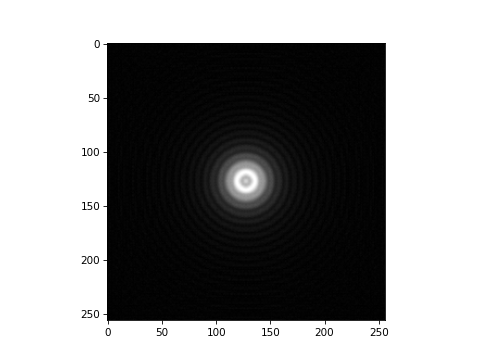

In [8]:
y0 = x0

t1 = Scalar_mask_XY(x0, y0, wavelength)
t1.lens(r0=(0, 0), radius=(radius, radius), focal=focal)

u0 = Scalar_source_XY(x0, y0, wavelength)
u0.plane_wave(A=1, theta=0)
u1 = u0 * t1

uend = FresnelPropagator(u1.u, dx, wavelength, focal + defocus)

plt.figure()
plt.imshow(np.abs(uend), cmap='gray')

In [9]:
W = radius * 2
n_g = 2000
wo = 0.006
OF = (2 * wo * n_g) / W
OF

3.0

In [10]:
pixel_size = dx

det_shape = (256, 256)

components = (
    comp.GaussBeam(
        z=z_start,
        voltage=calculate_phi_0(wavelength),
        radius=radius,
        wo=wo,
    ),
    comp.Lens(
        z=z_lens,
        f=focal,
    ),
    comp.AccumulatingDetector(
        z=z_end + defocus,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=1,
        interference='gauss'
    ),
)

det_size_y = det_shape[0] * pixel_size
det_size_x = det_shape[1] * pixel_size

x_det = xp.linspace(-det_size_y / 2, det_size_y / 2, det_shape[0])
y_det = xp.linspace(-det_size_x / 2, det_size_x / 2, det_shape[1])

model = Model(components, backend='gpu')
rays = tuple(model.run_iter(num_rays=n_g, random=False))

gbd_output_field = model.detector.get_image(rays[-1])

plt.figure()
plt.imshow(np.abs(gbd_output_field), cmap='gray')

gbd_end_field = gbd_output_field[size_x//2, :]
wpm_end_field = uend[size_x//2, :]

gbd_end_field_amp_norm = np.abs(gbd_end_field) / np.max(np.abs(gbd_end_field))
wpm_end_field_amp_norm = np.abs(wpm_end_field) / np.max(np.abs(wpm_end_field))

TypeError: AccumulatingDetector.__init__() got an unexpected keyword argument 'interference'

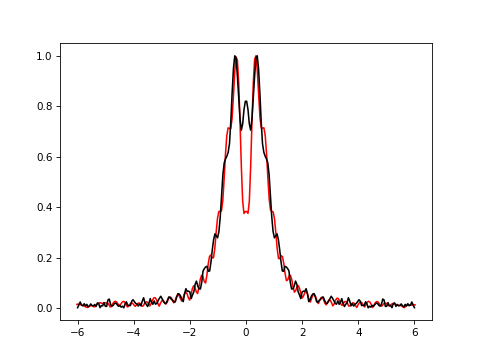

In [ ]:
# extent = [x0[0], x0[-1]]
plt.figure()
plt.plot(x_det, gbd_end_field_amp_norm, label="GBD", color = 'red')
plt.plot(x0, wpm_end_field_amp_norm, label="WPM", color = 'k')

In [ ]:
#Test Spherical aberration, distortion and coma

In [ ]:
#Test Aperture Diffraction Pattern

In [ ]:
#Test Arago Spot

In [ ]:
#Test Sample Decomposition

In [ ]:
# Test Biprism

In [ ]:
import sympy as sp
sp.init_printing()

# start_to_lens_transfer_matrix = np.array([[1, np.abs(z1)], [0, 1]])
# lens_transfer_matrix = np.array([[1, 0], [-1/focal, 1]])
# lens_to_end_transfer_matrix = np.array([[1, np.abs(z2)], [0, 1]])
z1_sym, z2_sym, focal_sym = sp.symbols('z1 z2 focal')

start_to_lens_transfer_matrix_sym = sp.Matrix([[1, focal_sym], [0, 1]])
lens_transfer_matrix_sym = sp.Matrix([[1, 0], [-1/focal_sym, 1]])
lens_to_end_transfer_matrix_sym = sp.Matrix([[1, focal_sym], [0, 1]])

final_matrix = lens_to_end_transfer_matrix_sym @ lens_transfer_matrix_sym @ start_to_lens_transfer_matrix_sym
display(final_matrix)

⎡  0    focal⎤
⎢            ⎥
⎢ -1         ⎥
⎢─────    0  ⎥
⎣focal       ⎦